<Strong> Note to the reader: </Strong> This notebook currently calculates the Auto count-count correlations of the PanSTARRS data and CMASS/LOWZ data. See notes on fixes and future things. </br>

Annotations about TreeCorr are taken from the documentation and all credit goes to Mike Jarvis. </br>

https://rmjarvis.github.io/TreeCorr/_build/html/overview.html </br>

-MT 5/14/20 9am

#### List of changes/fixes that are not resolved: 

- Data for panstarrs is outside the pointing? --- NEED TO INVESTIGATE 
- Corr func asymptotes to .2 instead of zero? Ross: Look as CMASS and LOWZ auto corr to check for zero corr function. --- NEED TO DO 
- Check papers for plots to compare --- NEED TO FINISH
- Theory calculuation for CMASS plots --- COULD DO 
- Better way to populate the randoms into the mask? Apply the mask over top? --- FIX ME

### Imports and formatting: 

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image

In [2]:
#plt.switch_backend('agg') #For HEP, matplotlib x windows issues see python version for more usage 
import treecorr
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

### Define notebook wide functions and data paths to use:

In [3]:
dataPath = '/Users/megantabbutt/CosmologyDataProducts/'
#dataPath = '/afs/hep.wisc.edu/home/tabbutt/private/CosmologyDataProducts/'

# Python has datename, savfig folder fields, usually don't save this code just for monkeying around... 
# If wanted to save some plots, should invoke this, and add text file to the folder with notes for that run 

 <hr style="height:3px"> 


## 0. Pull in and parse data:

note: There are 10 pointings for the PanSTARRS data, we will use all 10 for the Auto Correlation, but when we correlated to CMASS, we need to only use the 9 overlap with CMASS. --- IMPORTANT

#### PanSTARRS: 

In [4]:
connPAN = sqlite3.connect(dataPath + 'PanSTARRS.db')

qry = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"

PanSTARRSNEW_GoodZ = pd.read_sql(qry, con=connPAN)
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


#### CMASS/LOWZ:

In [5]:
connBOSS = sqlite3.connect(dataPath + 'CMASS_and_LOWZ.db')

qry = "SELECT * FROM CMASSLOWZTOT_South UNION SELECT * FROM CMASSLOWZTOT_North"

CMASSLOWZTOT_DF = pd.read_sql(qry, con=connBOSS)
CMASSLOWZTOT_DF.head(3) # 1.3 million objects

,index,RA,DEC,Z,NZ
0,0,195.071285,-0.590771,0.465648,0.000345
1,0,321.480329,9.973440,0.301401,0.000390
2,1,195.022992,-0.610999,0.565802,0.000319


#### Pull in the Randoms provided by CMASS:

In [6]:
connBOSSRands = sqlite3.connect(dataPath + 'CMASS_and_LOWZ_rands.db')
randSampleQry = "SELECT * FROM CMASSLOWZTOT_South_rands WHERE `index` IN (SELECT `index` FROM CMASSLOWZTOT_South_rands ORDER BY RANDOM() LIMIT 50000) UNION SELECT * FROM CMASSLOWZTOT_North_rands WHERE `index` IN (SELECT `index` FROM CMASSLOWZTOT_North_rands ORDER BY RANDOM() LIMIT 50000)"
randQry = "SELECT * FROM CMASSLOWZTOT_South_rands UNION SELECT * FROM CMASSLOWZTOT_North_rands"

CMASSLOWZTOT_DF_rands = pd.read_sql(randSampleQry, con=connBOSSRands)
CMASSLOWZTOT_DF_rands.to_json(dataPath + "CMASSLOWZTOT_DF_rands")
CMASSLOWZTOT_DF_rands.head(3)

,index,RA,DEC,Z,NZ
0,82,342.428140,1.740540,0.689022,0.000057
1,207,334.383378,22.128402,0.371309,0.000324
2,387,4.892873,-7.876945,0.155354,0.000660


In [7]:
connBOSS.close()
connBOSSRands.close()

 <hr style="height:3px"> 

## 1. Create the TreeCorr Catalogs of Data:

A set of input data (positions and other quantities) to be correlated.

A Catalog object keeps track of the relevant information for a number of objects to be correlated. The objects each have some kind of position (for instance (x,y), (ra,dec), (x,y,z), etc.), and possibly some extra information such as weights (w), shear values (g1,g2), or kappa values (k).

The simplest way to build a Catalog is to simply pass in numpy arrays for each piece of information you want included. 

> cat = treecorr.Catalog(ra=ra, dec=dec, g1=g1, g2=g2, ra_units='hour', dec_units='deg')

Other options for reading in from a file, using a config file, etc

In [8]:
catPanSTARRS = treecorr.Catalog(ra=PanSTARRSNEW_GoodZ['RA'], dec=PanSTARRSNEW_GoodZ['DEC'], ra_units='degrees', dec_units='degrees')
catPanSTARRS

Catalog(x=array([ 0.89821907,  0.79537251,  0.81322895, ..., -0.44845015,
       -0.86674663, -0.46424765]),y=array([-0.43906143,  0.60193276,  0.57531887, ...,  0.53951108,
        0.49764081,  0.55135371]),z=array([ 0.02067772, -0.07113031, -0.08756066, ...,  0.71261508,
        0.033225  ,  0.69316896]),ra=array([5.82852704, 0.6478348 , 0.61570853, ..., 2.26428363, 2.62039894,
       2.2706359 ]),dec=array([ 0.02067919, -0.07119043, -0.08767293, ...,  0.79321874,
        0.03323112,  0.76587641]),w=array([1., 1., 1., ..., 1., 1., 1.]))

## 2. Create the randoms for PanSTARRS
Include all ten pointings for now, can just exclude the pointing that isn't in CMASS when doing the CrossCorr </br>

Possibility to ask for mask eventually if we think that it is a limitation </br>

In [9]:
# Change this for more and less, 10E5 good for personal laptop ~5min run time
randsLength = 10**5

In [10]:
ra_min_PanSTARRS = numpy.min(catPanSTARRS.ra)
ra_max_PanSTARRS = numpy.max(catPanSTARRS.ra)
dec_min_PanSTARRS = numpy.min(catPanSTARRS.dec)
dec_max_PanSTARRS = numpy.max(catPanSTARRS.dec)
print('PanSTARRS ra range = %f .. %f' % (ra_min_PanSTARRS, ra_max_PanSTARRS))
print('PanSTARRS dec range = %f .. %f' % (dec_min_PanSTARRS, dec_max_PanSTARRS))

rand_ra_PanSTARRS = numpy.random.uniform(ra_min_PanSTARRS, ra_max_PanSTARRS, randsLength)
rand_sindec_PanSTARRS = numpy.random.uniform(numpy.sin(dec_min_PanSTARRS), numpy.sin(dec_max_PanSTARRS), randsLength)
rand_dec_PanSTARRS = numpy.arcsin(rand_sindec_PanSTARRS)

PanSTARRS ra range = 0.600713 .. 6.172202
PanSTARRS dec range = -0.506386 .. 1.038391


#### Note: MD02 is the one that needs to be eliminated, not in CMASS footprint 

In [11]:
# Got from a paper, need to cite it here:  https://arxiv.org/pdf/1612.05560.pdf

pointings = {"MD01": [035.875, -04.250], "MD03": [130.592, 44.317], "MD04": [150.000, 02.200], 
             "MD05": [161.917, 58.083], "MD06": [185.000, 47.117], "MD07": [213.704, 53.083], 
             "MD08": [242.787, 54.950], "MD09": [334.188, 00.283], "MD10": [352.312, -00.433], "MD02": [053.100, -27.800],}

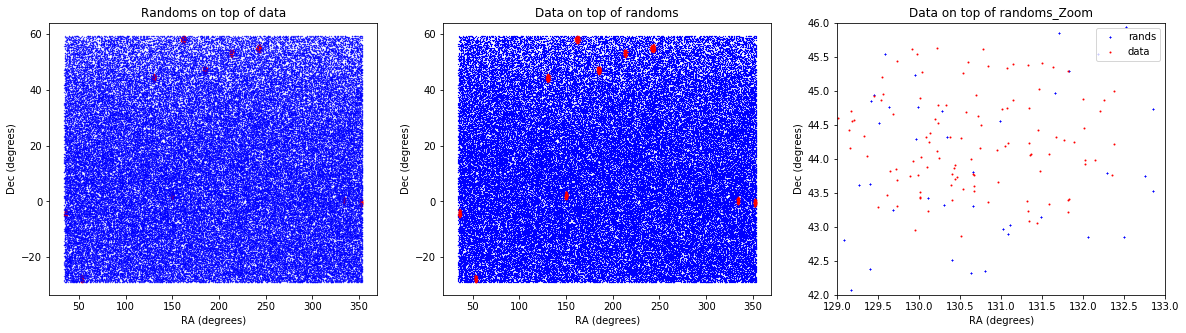

In [12]:
# Check how well the randoms cover the same space as the data

f1, (ax1a, ax2a, ax3a) = plt.subplots(1, 3, figsize=(20, 5))

ax1a.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax1a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=0.1)
ax1a.set_xlabel('RA (degrees)')
ax1a.set_ylabel('Dec (degrees)')
ax1a.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=0.1, marker='x')
ax2a.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=0.1)
ax2a.set_xlabel('RA (degrees)')
ax2a.set_ylabel('Dec (degrees)')
ax2a.set_title('Data on top of randoms')

# Zoom to look at coverage of randoms and reals
ax3a.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=1, marker='x', label='rands')
ax3a.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=1, label='data')
ax3a.set_xlabel('RA (degrees)')
ax3a.set_ylabel('Dec (degrees)')
ax3a.set_title('Data on top of randoms_Zoom')
ax3a.legend(loc = "upper right")
ax3a.set_xlim(129, 133)
ax3a.set_ylim(42, 46)

plt.show()

"The telescope illuminates a diameter of 3.3 degrees,  with low distortion, and mild vignetting at the edge of this illuminated region. The field of view is approximately 7 square degrees. The 8  meter  focal  length  atf/4.4  gives  an  approximate  10micron pixel scale of 0.258 arcsec/pixel."

7 square degrees --> r = 1.49 deg

In [13]:
# Make a mask that consists of the ten pointings populated with the randoms that are in it...
# Def a better way to do this? 

maskRA = []
maskDEC = []

for pointing in pointings: 
    maskRAprevious = len(maskRA)
    X0 = pointings[pointing][0]
    Y0 = pointings[pointing][1]
    rad = 3.3/2
    print(pointings[pointing])
    
    for i in range(len(rand_ra_PanSTARRS)):
        #print(rand_ra_PanSTARRS[i], rand_dec_PanSTARRS[i])
        X = rand_ra_PanSTARRS[i] * 180 / numpy.pi
        Y = rand_dec_PanSTARRS[i] * 180 / numpy.pi
        
        if ((X - X0)**2 + (Y - Y0)**2 < rad**2):
            maskRA.append(X)
            maskDEC.append(Y)
    print(len(maskRA) - maskRAprevious)

[35.875, -4.25]
31
[130.592, 44.317]
24
[150.0, 2.2]
39
[161.917, 58.083]
21
[185.0, 47.117]
34
[213.704, 53.083]
14
[242.787, 54.95]
12
[334.188, 0.283]
27
[352.312, -0.433]
26
[53.1, -27.8]
27


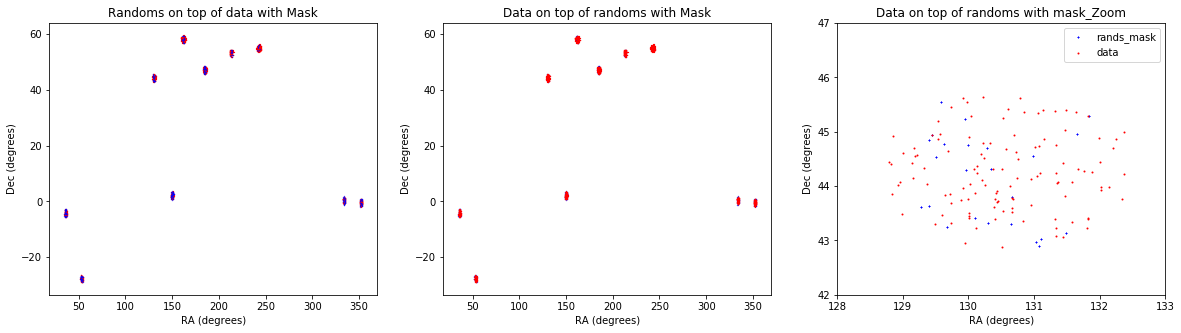

In [14]:
f2, (ax1b, ax2b, ax3b) = plt.subplots(1, 3, figsize=(20,5))

ax1b.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax1b.scatter(maskRA, maskDEC, color='blue', s=0.1)
ax1b.set_xlabel('RA (degrees)')
ax1b.set_ylabel('Dec (degrees)')
ax1b.set_title('Randoms on top of data with Mask')

# Repeat in the opposite order
ax2b.scatter(maskRA, maskDEC, color='blue', s=0.1)
ax2b.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax2b.set_xlabel('RA (degrees)')
ax2b.set_ylabel('Dec (degrees)')
ax2b.set_title('Data on top of randoms with Mask')

# Zoom to look at coverage of randoms and reals
ax3b.scatter(maskRA, maskDEC, color='blue', s=1, marker='x', label='rands_mask')
ax3b.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=1, label='data')
ax3b.set_xlabel('RA (degrees)')
ax3b.set_ylabel('Dec (degrees)')
ax3b.set_title('Data on top of randoms with mask_Zoom')
ax3b.legend(loc = "upper right")
ax3b.set_xlim(128, 133)
ax3b.set_ylim(42, 47)

plt.show()

## 3. Make PanSTARRS Count-Count Auto Correlation Functions:

Typical Usage Pattern:

> nn = treecorr.NNCorrelation(config) 
<br>
nn.process(cat)     # For auto-correlation.
<br>
nn.process(cat1,cat2)   # For cross-correlation.
<br>
rr.process...           # Likewise for random-random correlations
<br>
dr.process...        # If desired, also do data-random correlations
<br>
rd.process...    # For cross-correlations, also do the reverse.
<br>
nn.write(file_name,rr,dr,rd)  # Write out to a file.
<br>
xi,varxi = nn.calculateXi(rr,dr,rd)  # Or get the correlation function directly.

In [15]:
# Data Auto-correlation: (dd)
ddPanSTARRS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
ddPanSTARRS.process(catPanSTARRS)

In [16]:
rand = treecorr.Catalog(ra=maskRA, dec=maskDEC, ra_units='degrees', dec_units='degrees')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rr.process(rand)

In [17]:
dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dr.process(catPanSTARRS, rand)

In [18]:
r = numpy.exp(ddPanSTARRS.meanlogr)
xi, varxi = ddPanSTARRS.calculateXi(rr, dr)
sig = numpy.sqrt(varxi)

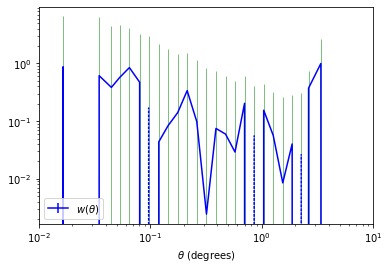

In [19]:
# Plot the Correlation function:

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='green', lw=0.5, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

## 4. Make CMASS Count-Count Auto Correlation Functions:

Typical Usage Pattern:

> nn = treecorr.NNCorrelation(config) 
<br>
nn.process(cat)     # For auto-correlation.
<br>
nn.process(cat1,cat2)   # For cross-correlation.
<br>
rr.process...           # Likewise for random-random correlations
<br>
dr.process...        # If desired, also do data-random correlations
<br>
rd.process...    # For cross-correlations, also do the reverse.
<br>
nn.write(file_name,rr,dr,rd)  # Write out to a file.
<br>
xi,varxi = nn.calculateXi(rr,dr,rd)  # Or get the correlation function directly.

In [20]:
catCMASS = treecorr.Catalog(ra=CMASSLOWZTOT_DF['RA'], dec=CMASSLOWZTOT_DF['DEC'], 
                                ra_units='degrees', dec_units='degrees')
catCMASS

Catalog(x=array([-0.96555174,  0.77057095, -0.96576697, ..., -0.75908709,
       -0.75899836, -0.75843631]),y=array([-0.26000679, -0.61337188, -0.25919189, ..., -0.07245224,
       -0.07669372, -0.07611541]),z=array([-0.01031072,  0.17319164, -0.01066374, ...,  0.64694471,
        0.64655979,  0.64728727]),ra=array([3.4046362 , 5.61089021, 3.40379332, ..., 3.23675093, 3.2422968 ,
       3.24161609]),dec=array([-0.0103109 ,  0.17406936, -0.01066394, ...,  0.70357085,
        0.70306617,  0.70402018]),w=array([1., 1., 1., ..., 1., 1., 1.]))

In [21]:
# Data Auto-correlation: (dd)
ddCMASS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
ddCMASS.process(catCMASS)

In [22]:
randCMASS = treecorr.Catalog(ra=CMASSLOWZTOT_DF_rands['RA'], dec=CMASSLOWZTOT_DF_rands['DEC'], ra_units='degrees', dec_units='degrees')
rrCMASS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rrCMASS.process(randCMASS)

In [23]:
drCMASS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
drCMASS.process(catCMASS, randCMASS)

In [24]:
rCMASS = numpy.exp(ddCMASS.meanlogr)
xiCMASS, varxiCMASS = ddCMASS.calculateXi(rrCMASS, drCMASS)
sigCMASS = numpy.sqrt(varxiCMASS)

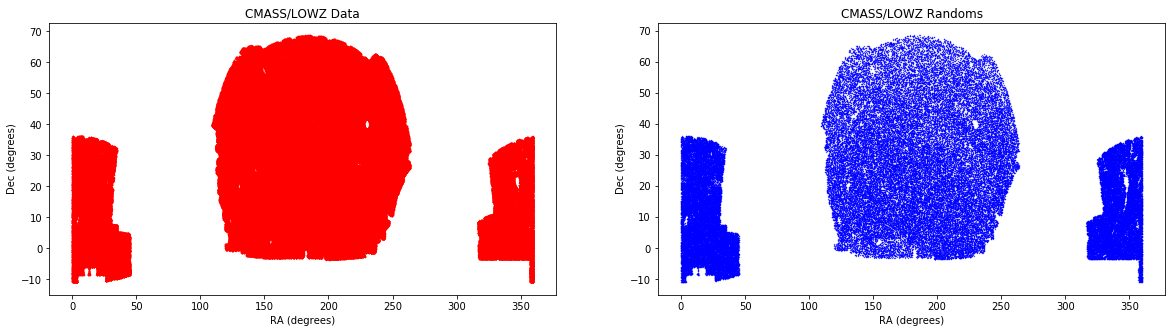

In [25]:
# Check that the randoms cover the same space as the data
f3, (ax1c, ax2c) = plt.subplots(1, 2, figsize=(20, 5))

ax1c.scatter(catCMASS.ra * 180/numpy.pi, catCMASS.dec * 180/numpy.pi, color='red', s=0.1)
ax1c.set_xlabel('RA (degrees)')
ax1c.set_ylabel('Dec (degrees)')
ax1c.set_title('CMASS/LOWZ Data')

# Repeat in the opposite order
ax2c.scatter(CMASSLOWZTOT_DF_rands['RA'], CMASSLOWZTOT_DF_rands['DEC'], color='blue', s=0.1)
ax2c.set_xlabel('RA (degrees)')
ax2c.set_ylabel('Dec (degrees)')
ax2c.set_title('CMASS/LOWZ Randoms')

plt.show()

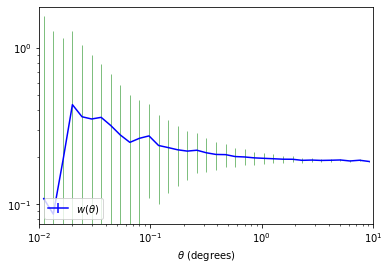

In [26]:
# Plot the autocorrelation function: 

plt.plot(rCMASS, xiCMASS, color='blue')
plt.plot(rCMASS, -xiCMASS, color='blue', ls=':')
plt.errorbar(rCMASS[xiCMASS>0], xiCMASS[xiCMASS>0], yerr=sigCMASS[xiCMASS>0], color='green', lw=0.5, ls='')
plt.errorbar(rCMASS[xiCMASS<0], -xiCMASS[xiCMASS<0], yerr=sigCMASS[xiCMASS<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-rCMASS, xiCMASS, yerr=sigCMASS, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

## 5. Analyze if the plots are correct: 

The CMASS plot should look like this paper's figure 1: </br>

https://arxiv.org/pdf/1607.03144.pdf



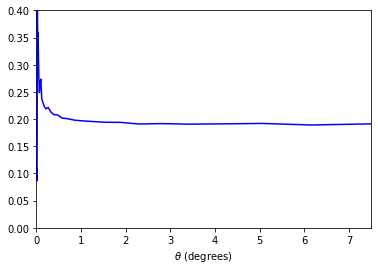

In [27]:
rCMASS = numpy.exp(ddCMASS.meanlogr)
xiCMASS, varxiCMASS = ddCMASS.calculateXi(rrCMASS, drCMASS)
sigCMASS = numpy.sqrt(varxiCMASS)

plt.plot(rCMASS, xiCMASS, color='blue')
plt.plot(rCMASS, -xiCMASS, color='blue', ls=':')
#plt.errorbar(rCMASS[xiCMASS>0], xiCMASS[xiCMASS>0], yerr=sigCMASS[xiCMASS>0], color='green', lw=0.5, ls='')
#plt.errorbar(rCMASS[xiCMASS<0], -xiCMASS[xiCMASS<0], yerr=sigCMASS[xiCMASS<0], color='green', lw=0.5, ls='')
#leg = plt.errorbar(-rCMASS, xiCMASS, yerr=sigCMASS, color='blue')

#plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.0, 7.5])
plt.ylim([0.0, .4])
plt.show()

My plot vs Theirs:

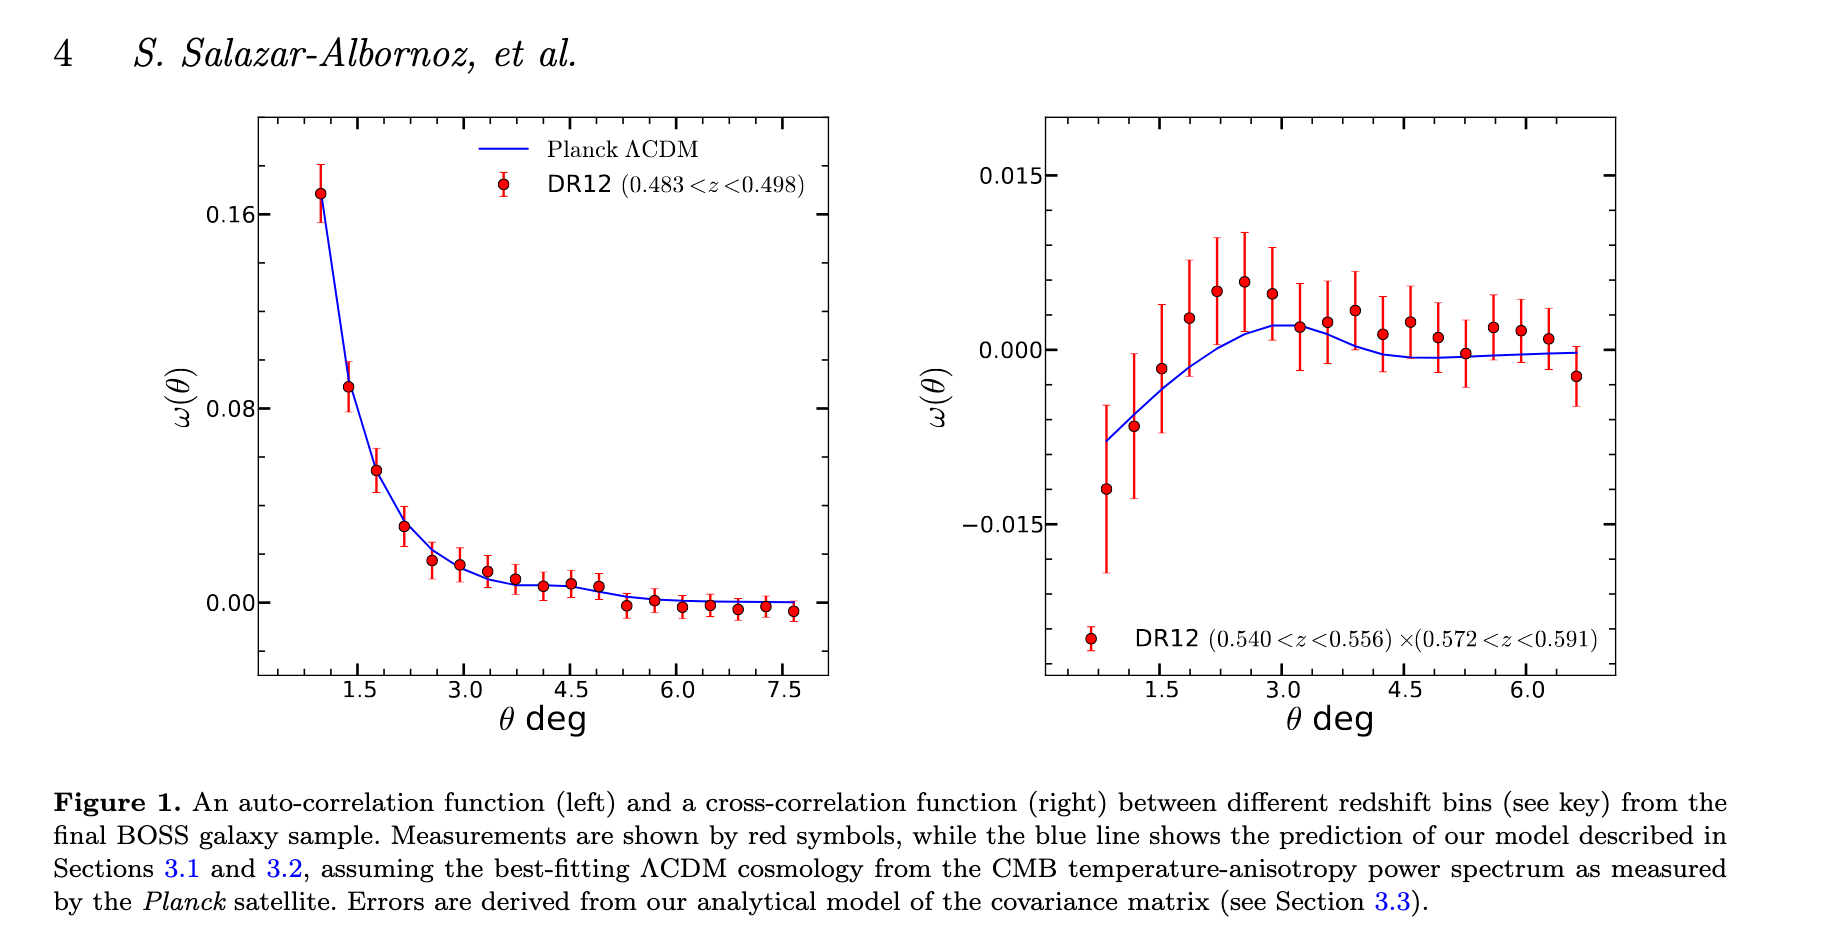

In [28]:
Image("/Users/megantabbutt/Desktop/ObservationalCosmology/SNeProject/Data_pictures_informal/5_14_20/plot1.jpeg")